In [ ]:
%tensorflow_version 2.x
from glob import glob
from keras import optimizers
from keras.applications.xception import Xception
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
path = glob("kaibara/*/")
data = []
label = [] 
total = 0
x = 160
y = 90

def append_data(directory, total):
  files = os.listdir(directory)
  print(files)
  for image in files:
    if image.endswith(".jpg"):
      image = cv2.imread(directory + image)
      image = cv2.resize(image, (x, y))
      image = image.flatten()
      data.append(image)
      label.append(total)

for i in path:
  append_data(i, total)
  total += 1

['kaibara_099.jpg', 'kaibara_100.jpg', 'kaibara_102.jpg', 'kaibara_104.jpg', 'kaibara_105.jpg', 'kaibara_106.jpg', 'kaibara_107.jpg', 'kaibara_108.jpg', 'kaibara_109.jpg', 'kaibara_110.jpg', 'kaibara_111.jpg', 'kaibara_112.jpg', 'kaibara_113.jpg', 'kaibara_115.jpg', 'kaibara_116.jpg', 'kaibara_118.jpg', 'kaibara_119.jpg', 'kaibara_120.jpg', 'kaibara_121.jpg', 'kaibara_122.jpg', 'kaibara_123.jpg', 'kaibara_124.jpg', 'kaibara_125.jpg', 'kaibara_126.jpg', 'kaibara_127.jpg', 'kaibara_128.jpg', 'kaibara_129.jpg', 'kaibara_130.jpg', 'kaibara_131.jpg', 'kaibara_132.jpg', 'kaibara_133.jpg', 'kaibara_134.jpg', 'kaibara_135.jpg', 'kaibara_136.jpg', 'kaibara_137.jpg', 'kaibara_138.jpg', 'kaibara_139.jpg', 'kaibara_140.jpg', 'kaibara_141.jpg', 'kaibara_142.jpg', 'kaibara_143.jpg', 'kaibara_144.jpg', 'kaibara_145.jpg', 'kaibara_146.jpg', 'kaibara_147.jpg', 'kaibara_148.jpg', 'kaibara_149.jpg', 'kaibara_150.jpg', 'kaibara_151.jpg', 'kaibara_152.jpg', 'kaibara_153.jpg', 'kaibara_154.jpg', 'kaibara_15

In [ ]:
data = np.array(data, dtype=np.float64)
label = np.array(label, dtype=np.float64)

train_data, test_data, train_label, test_label = train_test_split(data, label, random_state=1, stratify=label, test_size=0.2)

train_data = train_data.reshape((len(train_data)), x, y, 3)
test_data = test_data.reshape((len(test_data)), x, y, 3)

train_data /= 255
test_data /= 255

train_label = to_categorical(train_label, num_classes=2)
test_label = to_categorical(test_label, num_classes=2)
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(1028, 160, 90, 3)
(1028, 2)
(257, 160, 90, 3)
(257, 2)


In [ ]:
model = Xception(include_top=False, weights="imagenet", input_shape=None)
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation="relu")(x)
output = Dense(2, activation="softmax")(x)
model_x = Model(inputs=model.input, outputs=output)
print("{}層".format(len(model_x.layers)))
for layer in model_x.layers[:64]:
  layer.trainable = False
  if layer.name.startswith("batch_normalization"):
    layer.trainable = True
  if layer.name.endswith("bn"):
    layer.trainable = True
for layer in model_x.layers[64:]:
  layer.trainable = True
model_x.compile(optimizer=RMSprop(), loss="categorical_crossentropy", metrics=["accuracy"])
model_x.summary()

83689472/83683744 [==============================] - 1s 0us/step
135層
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
________________________

In [ ]:
data_generator = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 36,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=16, verbose=1)
result = model_x.fit_generator(data_generator.flow(train_data, train_label, batch_size=16), epochs=256, verbose=1, validation_data=(test_data, test_label), callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/256
65/65 [==============================] - 47s 129ms/step - loss: 0.6040 - accuracy: 0.7946 - val_loss: 1.5413 - val_accuracy: 0.8405
Epoch 2/256
65/65 [==============================] - 5s 82ms/step - loss: 0.4587 - accuracy: 0.8461 - val_loss: 8.9577 - val_accuracy: 0.8405
Epoch 3/256
65/65 [==============================] - 5s 82ms/step - loss: 0.4068 - accuracy: 0.8452 - val_loss: 13.0319 - val_accuracy: 0.8560
Epoch 4/256
65/65 [==============================] - 5s 81ms/step - loss: 0.2694 - accuracy: 0.8976 - val_loss: 47.8570 - val_accuracy: 0.8405
Epoch 5/256
65/65 [==============================] - 5s 82ms/step - loss: 0.3166 - accuracy: 0.9096 - val_loss: 2.0184 - val_accuracy: 0.8833
Epoch 6/256
65/65 [==============================] - 5s 83ms/step - loss: 0.1785 - accuracy: 0.9421 - val_loss: 0.6007 - val_accuracy: 0.8716
Epoch 7/256
65/65 [==============================] - 5s 82ms/step - loss: 0.1882 - accuracy: 0.9349 - val_loss: 1.0851 - val_accuracy: 0.9144
Ep

In [ ]:
print(model_x.evaluate(train_data, train_label))
print(model_x.evaluate(test_data, test_label))

33/33 [==============================] - 1s 40ms/step - loss: 0.0452 - accuracy: 0.9971
[0.04522954672574997, 0.9970816969871521]
9/9 [==============================] - 0s 35ms/step - loss: 0.1286 - accuracy: 0.9689
[0.12862297892570496, 0.9688715934753418]


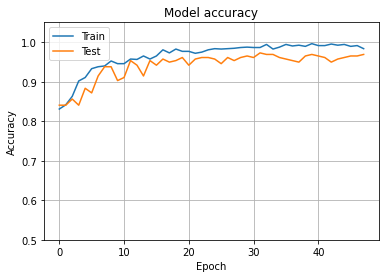

In [ ]:
plt.plot(result.history["accuracy"])
plt.plot(result.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(0.5, 1.05)
plt.grid()
plt.show()

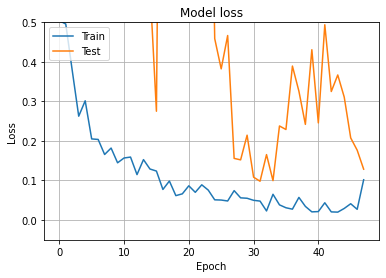

In [ ]:
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(-0.05, 0.5)
plt.grid()
plt.show()

In [ ]:
model_x.save("kaibara.h5")